In [3]:
import sys

from pathlib import Path
from datetime import timedelta

import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
#from TaPR_pkg import etapr

## 데이터 전처리
학습 데이터와 테스트 데이터는 CSV로 제공
HAI 2.0은 단일파일이 아니라 여러 파일로 제공되기 때문에 디렉토리 안에 있는 모든 CSV를 읽는다.

In [4]:
TRAIN_DATASET = sorted([x for x in Path("data/training/").glob("*.csv")])
TRAIN_DATASET

[WindowsPath('data/training/train1.csv'),
 WindowsPath('data/training/train2.csv'),
 WindowsPath('data/training/train3.csv')]

In [5]:
TEST_DATASET = sorted([x for x in Path("data/testing/").glob("*.csv")])
TEST_DATASET

[WindowsPath('data/testing/test1.csv'),
 WindowsPath('data/testing/test2.csv'),
 WindowsPath('data/testing/test3.csv'),
 WindowsPath('data/testing/test4.csv')]

In [6]:
VALIDATION_DATASET = sorted([x for x in Path("data/validation/").glob("*.csv")])
VALIDATION_DATASET

[WindowsPath('data/validation/validation.csv')]

In [7]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x:x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

TRAIN_DF_RAW는 공격을 받지 않는 평상시 데이터
시간을 나타내는 필드인 time
나머지는 모두 비식별화된 센서/액추에이터의 값
    -> 정규화는 센서/액추에이터 값만 대상으로


In [8]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW.head()

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-11 00:00:00,395.19528,12,10,52.80456,-1.2648,-1.87531,779.59595,28.02645,10832.0,...,808.29620,0.0,1.36810,8.79882,35.43700,12.01782,305.03113,301.35992,33.6555,6.0951
1,2020-07-11 00:00:01,395.14420,12,10,52.78931,-1.3147,-1.88294,780.67328,28.02473,10984.0,...,819.16809,0.0,1.36810,8.78811,35.45227,12.01782,304.27161,297.43567,33.6555,5.9262
2,2020-07-11 00:00:02,395.14420,12,10,52.79694,-1.4032,-1.88294,780.06574,28.02817,11120.0,...,823.51697,0.0,1.36734,8.81787,35.45227,12.01782,303.89179,298.66534,33.6555,5.8101
3,2020-07-11 00:00:03,395.19528,12,10,52.79694,-1.6074,-1.88294,780.15265,28.02301,11256.0,...,823.95172,0.0,1.36734,8.87493,35.43700,12.01782,303.67474,298.06860,33.6555,5.7509
4,2020-07-11 00:00:04,395.34866,12,10,52.79694,-1.7811,-1.88294,781.83160,28.03595,11384.0,...,827.86560,0.0,1.36810,8.83838,35.45227,12.01782,303.22266,296.53137,33.6555,5.8547


In [9]:
TRAIN_DF_RAW.columns

Index(['time', 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09',
       'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19',
       'C20', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29',
       'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39',
       'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49',
       'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59',
       'C60', 'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69',
       'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

해당 문서에서는 전체 데이터를 대상으로 이상을 탐지 "attack" 필드만 사용

VALID_COLUMNS_IN_TRAIN_DATASET은 학습 데이터셋에 있는 모든 센서/액추에이터 필드를 담고 있다.

In [10]:
TIMESTAMP_FIELD = "time"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79'],
      dtype='object')

TAG_MIN, TAG_MAX 학습 데이터셋에서 최솟값, 쵀댓값을 얻은 결과

In [11]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

### DATAFRAME 정규화

최솟값, 최댓값을 이용하여 0~1의 범위에 들어오도록
값이 전혀 변하지 않는 필드에 대해서는 최솟값, 최댓값이 같은 것 본 문서에서는 이런 필드를 0으로

In [12]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

TRAIN_DF 정규화를 마치고 exponential weighted function을 통과시킴
센서에서 발생하는 noise를 smotthing 시켜주기를 기대했다고 함

In [13]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.378953,0.0,0.0,0.227071,0.372380,0.000230,0.386721,0.410567,0.784144,0.508049,...,0.584892,0.0,0.326835,0.254687,0.331076,0.916661,0.269393,0.265017,1.00000,0.567254
1,0.378504,0.0,0.0,0.226596,0.353516,0.000161,0.399074,0.364415,0.794139,0.540538,...,0.592044,0.0,0.326835,0.254315,0.337223,0.916661,0.266791,0.251792,1.00000,0.512135
2,0.378463,0.0,0.0,0.226789,0.318663,0.000154,0.393283,0.451729,0.803903,0.538802,...,0.595523,0.0,0.326387,0.255304,0.337777,0.916661,0.265266,0.254707,1.00000,0.469622
3,0.378904,0.0,0.0,0.226808,0.238782,0.000154,0.393697,0.323289,0.813725,0.459532,...,0.596151,0.0,0.326343,0.257362,0.331746,0.916661,0.264379,0.253005,1.00000,0.446285
4,0.380282,0.0,0.0,0.226810,0.165794,0.000154,0.412796,0.654203,0.823039,0.333541,...,0.598763,0.0,0.326786,0.256312,0.337229,0.916661,0.262757,0.247706,1.00000,0.477489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
478796,0.302372,0.0,0.0,0.703684,0.509016,0.000538,0.420902,0.355242,0.064622,0.639006,...,0.683154,0.0,0.300845,0.497901,0.202699,0.111119,0.315343,0.248152,0.26162,0.757619
478797,0.304595,0.0,0.0,0.703684,0.485295,0.000538,0.481569,0.335967,0.061671,0.685457,...,0.680815,0.0,0.300850,0.497868,0.196619,0.111119,0.309817,0.245953,0.26162,0.681373
478798,0.304373,0.0,0.0,0.703684,0.386965,0.000538,0.497306,0.519990,0.058250,0.607073,...,0.677466,0.0,0.301298,0.497555,0.196011,0.111119,0.303620,0.236562,0.26162,0.631425
478799,0.306574,0.0,0.0,0.703684,0.289108,0.000538,0.468238,0.422572,0.055304,0.430538,...,0.683078,0.0,0.300895,0.494969,0.202036,0.111119,0.308706,0.266275,0.26162,0.677024


boundary_check 함수는 값이 0이상 1이하인지, NaN이 있는지 점검

In [14]:
def boundary_check(df):
    x=np.array(df, dtype=np.float32)
    return np.any(x>1.0), np.any(x<0), np.any(np.isnan(x))
boundary_check(TRAIN_DF)

(False, False, False)

## 학습 모델 설정 & 데이터 입출력 정의
- 딥러닝 학습과 추론에는 PyTorch 사용
- Stacked RNN(GRU cells)을 이용해서 이상을 탐지
- 정상 데이터만 학습해야 하며, 정상 데이터에는 어떠한 label도 없으므로 unsupervised learning
- 본 모델에서는 슬라이딩 윈도우를 통해 시계열 데이터의 일부를 가져와서 해당 윈도우의 패턴을 기억하도록 했다. 슬라이딩 윈도우는 90초(HAI는 1초마다 샘플링 되어 있슴)로 설정
- 모델의 입출력은 다음과 같이 설정   
    입력 : 윈도우의 앞부분 89초에 해당하는 값   
    출력 : 윈도우의 가장 마지막 초(90번채 초)의 값
- 이후 탐지 시에는 모델이 출력하는 값(예측값)과 실제로 들어온 값의 차를 보고 차이가 크면 이상으로 간주

In [24]:
WINDOW_GIVEN = 89
WINDOW_SIZE = 90


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

PyTorch의 Dataset 인터페이스를 정의한 것이 HaiDataset 클래스

데이터셋을 읽을 때는 슬라이딩 윈도우가 유효한지 점검.
정상적인 윈도우라면 첫 시각과 마지막 시각의 차가 89초

stride 파라미터는 슬라이딩을 할 때 크기를 의미
이 파일에서는 학습을 빠르게 마치기 위해 10초씩 건너뛰면서 데이터를 추출핟록 했음

In [21]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=10)
HAI_DATASET_TRAIN[0]


# of valid windows: 92134


{'ts': '2020-07-11 00:01:29',
 'given': tensor([[0.3790, 0.0000, 0.0000,  ..., 0.2650, 1.0000, 0.5673],
         [0.3785, 0.0000, 0.0000,  ..., 0.2518, 1.0000, 0.5121],
         [0.3785, 0.0000, 0.0000,  ..., 0.2547, 1.0000, 0.4696],
         ...,
         [0.3730, 0.0000, 0.0000,  ..., 0.4418, 1.0000, 0.5003],
         [0.3739, 0.0000, 0.0000,  ..., 0.4408, 1.0000, 0.5446],
         [0.3740, 0.0000, 0.0000,  ..., 0.4533, 1.0000, 0.5467]]),
 'answer': tensor([3.7401e-01, 0.0000e+00, 0.0000e+00, 2.2681e-01, 4.4518e-01, 1.5360e-04,
         3.0547e-01, 6.0378e-01, 4.1797e-01, 5.0237e-01, 5.1502e-01, 4.5891e-01,
         1.4508e-01, 0.0000e+00, 4.7930e-01, 3.5710e-01, 1.1150e-03, 0.0000e+00,
         0.0000e+00, 3.8993e-01, 0.0000e+00, 0.0000e+00, 2.0921e-04, 9.5674e-01,
         0.0000e+00, 4.0782e-01, 3.6943e-01, 0.0000e+00, 4.1359e-01, 1.3964e-01,
         9.8371e-01, 2.6923e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.8270e-01, 7.2178e-01, 0.0000e+00, 1.

모델은 3층 bidirectional GRU, Hidden cell의 크기는 100, Dropout은 사용하지 않음
모델이 윈도우의 가장 첫번째 값과 RNN의 출력을 더해서 내보내도록 skip connection을 만들었음

In [16]:
N_HIDDENS = 100
N_LAYERS = 3
BATCH_SIZE = 512


class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0,
        )
        self.fc = torch.nn.Linear(N_HIDDENS * 2, n_tags)

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = self.fc(outs[-1])
        return x[0] + out

In [17]:
MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
#MODEL.cuda()
MODEL

StackedGRU(
  (rnn): GRU(79, 100, num_layers=3, bidirectional=True)
  (fc): Linear(in_features=200, out_features=79, bias=True)
)

## 신규 모델 학습
모델 학습을 직접 하려면 아래 코드를 실행
이미 학습된 모델을 로드해서 결과만 보려면 아래 '모델 불러오기' section으로 가서 실행을 이어가면 됨
Loss Function은 MSE 선택, optimizer는 AdamW 사용
학습시 epoch loss가 가장 좋았던 모델의 파라미터를 저장

In [29]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        for batch in dataloader:
            optimizer.zero_grad()
            #given = batch["given"].cuda()
            given = batch["given"]
            
            guess = model(given)
            #answer = batch["answer"].cuda()
            answer = batch["answer"]
            
            loss = loss_fn(answer, guess)
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        loss_history.append(epoch_loss)
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
        if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = e + 1
    return best, loss_history

학습은 32 에포크 진행

In [30]:
%%time
MODEL.train()
BEST_MODEL, LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, 32)


Wall time: 8h 9min 27s


In [31]:
BEST_MODEL["loss"], BEST_MODEL["epoch"]

(0.08519277049344964, 32)

In [32]:
with open("model.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL["state"],
            "best_epoch": BEST_MODEL["epoch"],
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

## 모델 불러오기
이미 학습된 모델 파라미터와 training loss 기록을 불러온다.

In [18]:
with open("model.pt", "rb") as f:
    SAVED_MODEL = torch.load(f)

MODEL.load_state_dict(SAVED_MODEL["state"])

<All keys matched successfully>

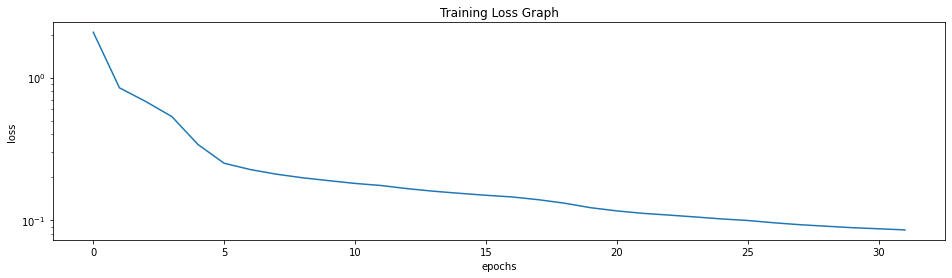

In [19]:
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(SAVED_MODEL["loss_history"])
plt.show()

## 학습된 모델을 이용한 탐지
검증 데이터셋을 불러와서 모델에 입력으로 주고 예측값과 실제값의 차를 얻어본다.
검증 데이터셋에 대해서도 만들어둔 함수를 이용해서 점검해본다.

In [20]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C71,C72,C73,C74,C75,C76,C77,C78,C79,attack
0,2020-07-07 15:00:00,402.70947,12.0,10,51.95007,-1.0189,-1.86768,789.76508,28.03162,688,...,0.0,1.34293,10.89290,34.88770,12.26196,380.31683,386.26666,32.59527,5.6330,0
1,2020-07-07 15:00:01,402.81174,12.0,10,51.96533,-1.2637,-1.86768,789.13147,28.02301,648,...,0.0,1.34216,10.80512,34.88770,12.26196,380.02747,386.30286,32.59527,5.4158,0
2,2020-07-07 15:00:02,402.76062,12.0,10,51.96533,-1.5398,-1.86768,785.81653,28.02993,616,...,0.0,1.34369,10.80029,34.88770,12.26196,381.52850,389.73883,32.59527,5.5532,0
3,2020-07-07 15:00:03,402.81174,12.0,10,51.98822,-1.6212,-1.86768,785.42438,28.02993,584,...,0.0,1.34445,10.80579,34.88770,12.26196,382.08911,388.94311,32.59527,5.7833,0
4,2020-07-07 15:00:04,402.91394,12.0,10,51.90429,-1.5631,-1.86768,782.99249,28.02990,552,...,0.0,1.34293,10.81415,34.90295,12.26196,383.44543,389.72082,32.59527,6.0309,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43196,2020-07-08 02:59:56,397.08661,12.0,10,66.58325,-1.2052,-1.83716,786.93738,28.03250,0,...,0.0,1.35971,16.19496,35.22338,12.01019,390.13672,394.91107,31.81634,5.2977,0
43197,2020-07-08 02:59:57,397.18887,12.0,10,66.58325,-0.9256,-1.83716,783.44989,28.02304,0,...,0.0,1.35971,16.23927,35.23864,12.01019,390.24518,397.35248,31.81634,5.3188,0
43198,2020-07-08 02:59:58,397.13776,12.0,10,66.58325,-0.7843,-1.83716,784.86780,28.02814,0,...,0.0,1.35818,16.20675,35.23864,12.01019,390.46222,396.70142,31.81634,5.1800,0
43199,2020-07-08 02:59:59,397.34222,12.0,10,66.58325,-0.7646,-1.83716,785.51416,28.02294,0,...,0.0,1.35818,16.17168,35.25391,12.01019,391.78241,397.73218,31.81634,4.8763,0


검증 데이터셋 정규화 : 정상 데이터셋의 최솟값, 최댓값 사용

In [21]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET])

In [22]:
boundary_check(VALIDATION_DF)

(True, True, False)

공격 데이터셋에서는 확실히 정상 데이터의 최솟값과 최댓값을 벗어나는 값이 나타나고 있습니다.

In [25]:
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 43112


{'attack': 0.0,
 'ts': '2020-07-07 15:01:29',
 'given': tensor([[0.4516, 0.0000, 0.0000,  ..., 0.5798, 0.5271, 0.4014],
         [0.4526, 0.0000, 0.0000,  ..., 0.5799, 0.5271, 0.3234],
         [0.4521, 0.0000, 0.0000,  ..., 0.5927, 0.5271, 0.3727],
         ...,
         [0.5267, 0.0000, 0.0000,  ..., 0.3193, 0.5271, 0.3745],
         [0.5257, 0.0000, 0.0000,  ..., 0.3134, 0.5271, 0.4363],
         [0.5252, 0.0000, 0.0000,  ..., 0.3089, 0.5271, 0.5319]]),
 'answer': tensor([5.2717e-01, 0.0000e+00, 0.0000e+00, 1.6201e-01, 2.4634e-01, 3.0731e-04,
         4.7660e-01, 5.1151e-01, 1.1574e-03, 1.5182e-01, 4.9051e-01, 5.5063e-01,
         2.8699e-01, 0.0000e+00, 4.4413e-01, 4.3588e-01, 2.4863e-02, 0.0000e+00,
         0.0000e+00, 3.4310e-01, 0.0000e+00, 0.0000e+00, 7.5772e-01, 6.8562e-01,
         0.0000e+00, 3.7939e-01, 2.5223e-01, 0.0000e+00, 3.9106e-01, 2.5138e-02,
         9.9257e-01, 3.4135e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.1100e-01, 4.6915e-01

검증 데이터셋에 대해서도 PyTorch Dataset 인스턴스를 만들었다.  
모든 데이터 포인트에 대해 점검해야하므로 학습 데이터와는 다르게 슬라이딩 크기는 1

In [26]:
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            #given = batch["given"].cuda()
            given = batch["given"]
            #answer = batch["answer"].cuda()
            answer = batch["answer"]
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

inference 함수는 데이터를 순차적으로 보면서 모델이 예측한 값과 실제 값의 차를 구해서 기록합니다.

In [27]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

Wall time: 1min 31s


CHECK_DIST는 검증 데이터셋 전체 시간대에 대해 모든 필드의 |예측값 - 실제값|을 가지고 있습니다.

In [28]:
CHECK_DIST.shape

(43112, 79)

공격 여부 판단을 위해 같은 시각에서 전체 필드가 산출하는 차의 평균을 계산합니다.

In [29]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

결과를 눈으로 확인하기 위해 그래프를 그려보겠습니다.  
piece 파라미터는 그래프를 몇 개로 나누어 그릴지를 결정합니다.  
세세한 결과를 보고 싶을 경우 숫자를 늘리면 됩니다.

In [30]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

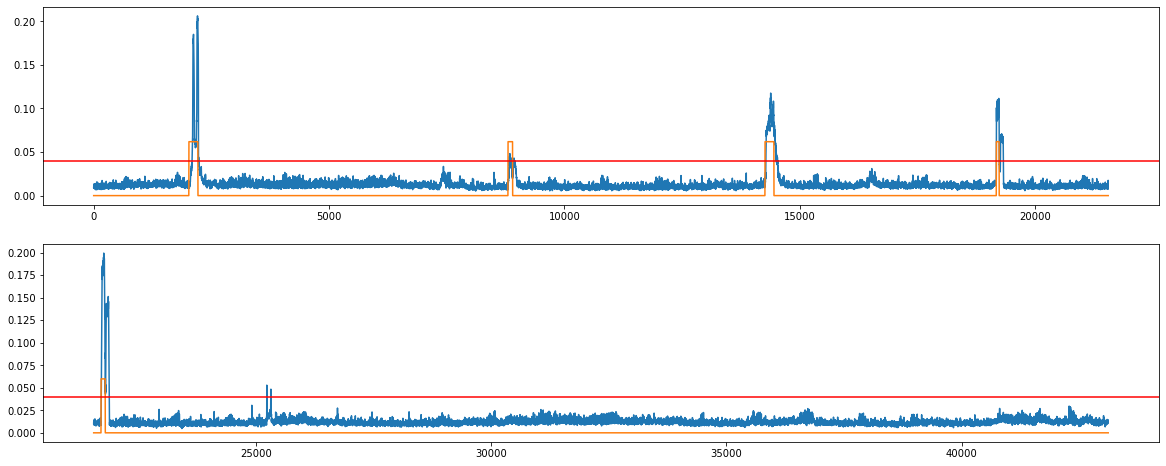

In [31]:
THRESHOLD = 0.04
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=2, THRESHOLD=THRESHOLD)

주황색 선은 공격 위치를 나타내고, 파란색 선은 (평균) 오차의 크기를 나타냅니다.  
전반적으로 공격 위치에서 큰 오차를 보이고 있습니다.

임의의 threshold(빨간색 선)가 넘어갈 경우 공격으로 간주합니다.  
공격은 1로 정상은 0으로 표기합니다.

In [32]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

위의 그래프를 보면 대략 0.04를 기준으로 설정할 수 있을 것으로 보입니다.
여러 번의 실험을 통해 정밀하게 임계치를 선택하면 더 좋은 결과를 얻을 수 있을 것으로 예상합니다.

In [33]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (43112,))

정답지(ATTACK_LABELS)도 동일하게 추출합니다.
검증 데이터셋에 공격 여부를 나타내는 필드에는 정상을 0으로 공격을 1로 표기하고 있습니다.
위에 정의한 put_labels 함수를 이용해서 0.5를 기준으로 같은 방식으로 TaPR을 위한 label을 붙여줍니다.

In [34]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64), (43201,))

탐지 모델이 윈도우 방식으로 판단을 진행했기 때문에,  
1. 첫 시작의 몇 초는 판단을 내릴 수 없고  
2. 데이터셋 중간에 시간이 연속되지 않는 구간에 대해서는 판단을 내릴 수 없습니다.  

위에서 보시는 바와 같이 정답에 비해 얻어낸 label의 수가 적습니다.  

아래의 fill_blank 함수는 빈칸을 채워줍니다.  
빈 곳은 정상(0) 표기하고 나머지는 모델의 판단(정상 0, 비정상 1)을 채워줍니다.  

In [35]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [36]:
%%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

Wall time: 5.19 s


(43201,)

## 평가

평가는 TaPR을 사용합니다.
정답(ATTACK_LABELS)과 모델의 결과(FINAL_LABELS)의 길이가 같은지 확인합니다.

In [55]:
ATTACK_LABELS.shape[0] == FINAL_LABELS.shape[0]

True

In [56]:
TaPR = etapr.evaluate(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

NameError: name 'etapr' is not defined

## 테스트 데이터셋 예측
학습 데이터셋과 검증 데이터셋을 이용해 만든 모델로 테스트 데이터셋 결과를 예측합니다.

In [37]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,time,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,2020-07-09 15:00:00,384.30737,12.0,10,70.35980,-1.6171,-1.79901,774.20752,28.02385,136,...,936.58447,0.0,1.35437,13.97231,35.22338,12.02545,293.51129,283.92651,32.0,6.5059
1,2020-07-09 15:00:01,384.30737,12.0,10,70.35980,-1.7606,-1.79901,772.58758,28.02730,136,...,940.93317,0.0,1.35437,13.93358,35.20813,12.02545,292.67938,283.36591,32.0,6.3079
2,2020-07-09 15:00:02,384.20517,12.0,10,70.35980,-1.7606,-1.80664,772.58758,28.02730,136,...,936.58447,0.0,1.35513,13.95248,35.20813,12.02545,291.90179,282.93189,32.0,6.3079
3,2020-07-09 15:00:03,384.25626,12.0,10,70.35980,-1.7814,-1.79901,777.48810,28.02905,136,...,933.54034,0.0,1.35513,13.89971,35.20813,12.02545,291.59430,282.06378,32.0,6.1203
4,2020-07-09 15:00:04,384.20517,12.0,10,70.35980,-1.7370,-1.79901,778.42212,28.03169,136,...,944.41223,0.0,1.35437,13.94603,35.20813,12.02545,289.87628,283.67334,32.0,5.9543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,2020-07-31 12:29:56,420.08923,12.0,10,48.31848,-0.8706,97.19238,786.54382,28.03253,232,...,824.82147,100.0,1.35666,9.62203,36.47460,11.78894,357.27722,361.14728,32.0,6.2809
92397,2020-07-31 12:29:57,420.08923,12.0,10,48.31848,-0.7498,97.19238,784.07184,28.03598,224,...,823.51697,100.0,1.35513,9.48747,36.47460,11.78894,357.29529,359.84521,32.0,6.3602
92398,2020-07-31 12:29:58,420.24258,12.0,10,48.31848,-0.6076,97.19238,786.83881,28.02642,208,...,824.82147,100.0,1.35666,9.57787,36.48986,11.78894,357.27722,360.60474,32.0,6.3742
92399,2020-07-31 12:29:59,420.24258,12.0,10,48.31848,-0.4618,97.19238,786.66138,28.03341,200,...,833.51904,100.0,1.35513,9.56291,36.48986,11.78894,357.80170,357.42188,32.0,6.2864


테스트 데이터셋도 정상 데이터셋의 최솟값, 최댓값을 이용해서 정규화합니다.

In [38]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79
0,0.273715,0.0,0.0,0.828325,0.225882,0.000999,0.318761,0.333825,0.010417,0.139867,...,0.677723,0.0,0.317842,0.452044,0.236483,0.944440,0.225971,0.200389,0.26162,0.714722
1,0.273715,0.0,0.0,0.828325,0.171634,0.000999,0.300187,0.426398,0.010417,0.137445,...,0.680584,0.0,0.317842,0.450701,0.230344,0.944440,0.223121,0.198499,0.26162,0.650106
2,0.272825,0.0,0.0,0.828325,0.166747,0.000930,0.298514,0.434738,0.010417,0.137227,...,0.678007,0.0,0.318290,0.451229,0.229791,0.944440,0.220223,0.196880,0.26162,0.644285
3,0.273182,0.0,0.0,0.828325,0.158478,0.000992,0.353980,0.482056,0.010417,0.190063,...,0.675769,0.0,0.318335,0.449470,0.229736,0.944440,0.218893,0.193823,0.26162,0.583093
4,0.272773,0.0,0.0,0.828325,0.174269,0.000998,0.370123,0.556914,0.010417,0.266280,...,0.682626,0.0,0.317891,0.450884,0.229731,0.944440,0.212932,0.198888,0.26162,0.523348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92396,0.619520,0.0,0.0,0.073426,0.532147,0.998079,0.476720,0.581066,0.017489,0.358745,...,0.596406,1.0,0.319337,0.285888,0.790598,0.083339,0.466152,0.485809,0.26162,0.622130
92397,0.619561,0.0,0.0,0.073426,0.581096,0.998079,0.446527,0.680775,0.016853,0.386044,...,0.595956,1.0,0.318439,0.281450,0.790543,0.083339,0.466370,0.482229,0.26162,0.658390
92398,0.620899,0.0,0.0,0.073426,0.639210,0.998079,0.474916,0.436791,0.015748,0.453718,...,0.596761,1.0,0.319252,0.284110,0.796619,0.083339,0.466330,0.484406,0.26162,0.666539
92399,0.621033,0.0,0.0,0.073426,0.699587,0.998079,0.475741,0.598077,0.015116,0.563381,...,0.602505,1.0,0.318431,0.283862,0.797227,0.083339,0.468106,0.474004,0.26162,0.638988


테스트 데이터셋에 대해서도 만들어둔 함수를 이용해서 점검해봅니다.  
Not a number가 있는지 점검하는 것이 주요 목적입니다.

In [39]:
boundary_check(TEST_DF)

(True, True, False)

In [40]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_VALIDATION[0]


# of valid windows: 358448


{'attack': 0.0,
 'ts': '2020-07-07 15:01:29',
 'given': tensor([[0.4516, 0.0000, 0.0000,  ..., 0.5798, 0.5271, 0.4014],
         [0.4526, 0.0000, 0.0000,  ..., 0.5799, 0.5271, 0.3234],
         [0.4521, 0.0000, 0.0000,  ..., 0.5927, 0.5271, 0.3727],
         ...,
         [0.5267, 0.0000, 0.0000,  ..., 0.3193, 0.5271, 0.3745],
         [0.5257, 0.0000, 0.0000,  ..., 0.3134, 0.5271, 0.4363],
         [0.5252, 0.0000, 0.0000,  ..., 0.3089, 0.5271, 0.5319]]),
 'answer': tensor([5.2717e-01, 0.0000e+00, 0.0000e+00, 1.6201e-01, 2.4634e-01, 3.0731e-04,
         4.7660e-01, 5.1151e-01, 1.1574e-03, 1.5182e-01, 4.9051e-01, 5.5063e-01,
         2.8699e-01, 0.0000e+00, 4.4413e-01, 4.3588e-01, 2.4863e-02, 0.0000e+00,
         0.0000e+00, 3.4310e-01, 0.0000e+00, 0.0000e+00, 7.5772e-01, 6.8562e-01,
         0.0000e+00, 3.7939e-01, 2.5223e-01, 0.0000e+00, 3.9106e-01, 2.5138e-02,
         9.9257e-01, 3.4135e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 4.1100e-01, 4.6915e-01

테스트 데이터셋에 대해서도 PyTorch Dataset 인스턴스를 만들었습니다.  
모든 데이터 포인트에 대해 점검해야 하므로 검증 데이터 때와 마찬가지로 슬라이딩의 크기는 1로 두어야 합니다.

inference 함수로 데이터를 순차적으로 보면서 모델이 예측한 값과 실제 값의 차를 구해서 기록합니다.

In [41]:
%%time
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

Wall time: 14min


공격 여부 판단을 위해 같은 시각에서 전체 필드가 산출하는 차의 평균을 계산합니다.

In [42]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

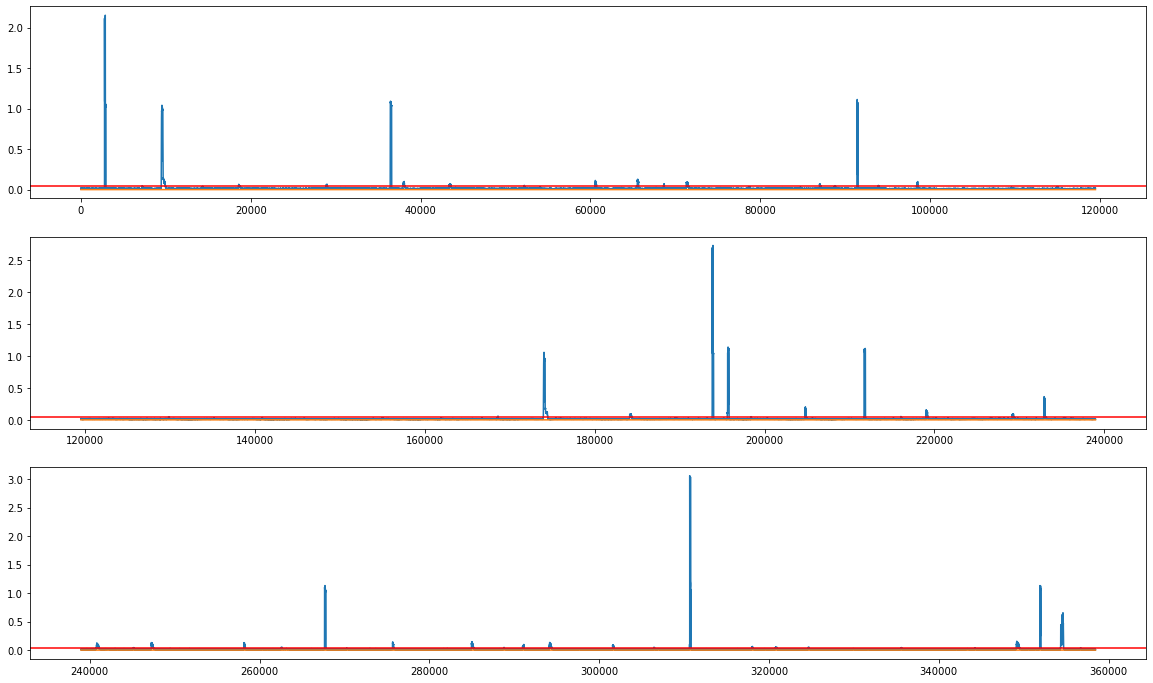

In [43]:
check_graph(ANOMALY_SCORE, CHECK_ATT, piece=3, THRESHOLD=THRESHOLD)

검증 데이터셋을 이용해 찾은 threshold를 이용해 공격 여부를 예측합니다.

In [44]:
LABELS = put_labels(ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (358448,))

예측한 결과를 제출양식에 맞춰 저장합니다.

In [45]:
submission = pd.read_csv('data/sample_submission.csv')
submission.index = submission['time']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,time,attack
time,,
2020-07-09 15:00:00,2020-07-09 15:00:00,0.0
2020-07-09 15:00:01,2020-07-09 15:00:01,0.0
2020-07-09 15:00:02,2020-07-09 15:00:02,0.0
2020-07-09 15:00:03,2020-07-09 15:00:03,0.0
2020-07-09 15:00:04,2020-07-09 15:00:04,0.0
...,...,...
2020-07-31 12:29:56,2020-07-31 12:29:56,0.0
2020-07-31 12:29:57,2020-07-31 12:29:57,0.0
2020-07-31 12:29:58,2020-07-31 12:29:58,0.0


예측한 결과를 저장하여 제출합니다.

In [46]:
submission.to_csv('baseline.csv', index=False)